# Lab 7 - Logistic Regression, ROCs and imputation


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
%matplotlib inline
import seaborn.apionly as sns

/Users/krader/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Asymmetry

First we'd like to simply notice that our data set is very highly asymmetric, with positives, or people who churned, only making up 14-15% of the samples.

In [2]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


In [3]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
excellenthealth = np.where(gssdata['health'] == 'excellent',1,0)
fairhealth = np.where(gssdata['health'] == 'fair',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['fairhealth'] = fairhealth
gssdata['excellenthealth'] = excellenthealth
100*gssdata.poorhealth.mean()

6.382978723404255

 This means that a classifier which predicts EVERY respondent to not be in excellent health will have an accuracy rate of 80-81%. 

But is accuracy the correct metric?

## Fit a logistic model ignoring missingness

Let's begin by fitting a logistic regression model to predict poor health based on all the other predictors in the model.  Be sure to regularize (with CV) to make sure we are not overfitting to the data.

First we need to do a small amount of data clean-up (ignoring missingness for now in income).

In [4]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

In [5]:
print(gssdata.shape)
gssdata.head()

(1551, 23)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,0,0,1,0,0,0,1,0,0,1
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,0,0,1,0,0,1,0,0,0,1
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,0,0,1,0,0,1,0,0,0,1


In [6]:
gssdata_full = gssdata.dropna(how = 'any')
print(gssdata_full.shape)
gssdata_full.head()

(963, 23)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
5,excellent,30,female,15,heterosexual or straight,other,other,1,18750.0,0,...,0,0,1,0,0,1,0,0,1,0
9,excellent,30,female,14,heterosexual or straight,other,black,1,16250.0,0,...,0,0,1,0,0,1,0,1,0,0
12,good,38,female,15,heterosexual or straight,dem,white,0,18750.0,0,...,0,0,1,0,1,0,0,0,0,1


In [7]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata_full.shape[0]), train_size=0.50)
#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]
X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_full['poorhealth'].iloc[itrain]
y_test = gssdata_full['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape



((481,), (481, 6), (482,), (482, 6))

In [8]:
gsstemp.head()
100*gssdata_full.poorhealth.mean()

1.6614745586708204

In [10]:
logit = LogisticRegression(C=1000000)
logit.fit(X_train, y_train) 
print(logit.score(X_test,y_test))
logit.coef_

0.98132780083


array([[  1.49652846e-02,  -2.27912388e-01,  -5.05742226e-03,
         -4.20029319e-03,  -2.04129455e-03,  -1.35496132e-04]])

## Remember the Confusion matrix? We reproduce it here for convenience

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



[[473   0]
 [  9   0]]


(array([ 366.,   53.,   25.,   15.,   11.,    6.,    1.,    2.,    1.,    1.]),
 array([ 0.00134795,  0.01716307,  0.03297818,  0.0487933 ,  0.06460842,
         0.08042353,  0.09623865,  0.11205377,  0.12786888,  0.143684  ,
         0.15949912]),
 <a list of 10 Patch objects>)

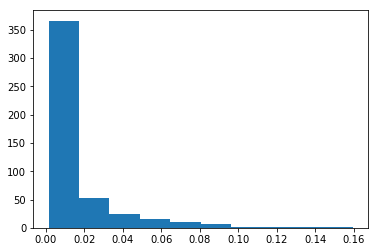

In [11]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,logit.predict(X_test)))
yhats = logit.predict_proba(X_train)
plt.hist(yhats[:,1])
#print(confusion_matrix(y_test,))


In [12]:
#manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

print(confusion_matrix(y_test,t_repredict(logit, 0.06, X_test)))
print(confusion_matrix(y_train,t_repredict(logit, 0.06, X_train)))

[[451  22]
 [  6   3]]
[[449  25]
 [  7   0]]


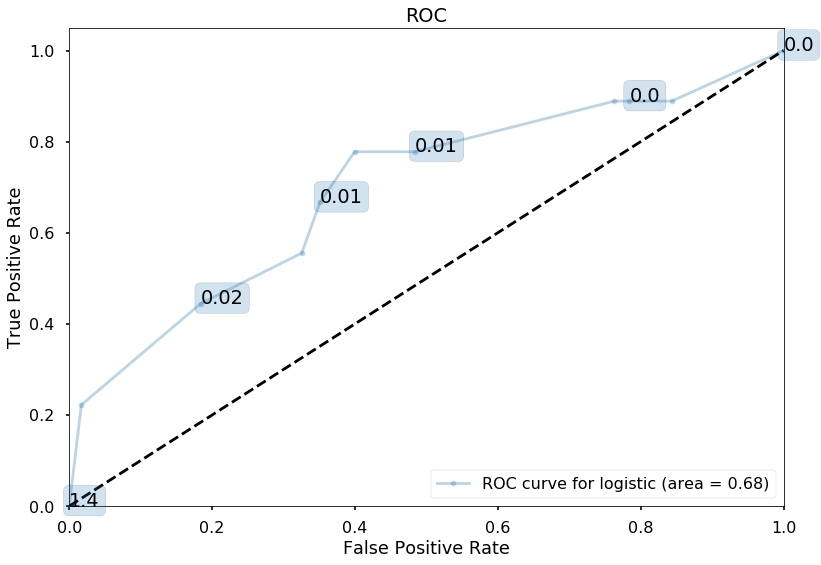

In [13]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

sns.set_context("poster")
ax=make_roc("logistic",logit, y_test, X_test, labe=10, skip=5)


## Let's get back the data with missingness

(array([  35.,   21.,   39.,   25.,   14.,   71.,    0.,   66.,   96.,  596.]),
 array([   500.,   2325.,   4150.,   5975.,   7800.,   9625.,  11450.,
         13275.,  15100.,  16925.,  18750.]),
 <a list of 10 Patch objects>)

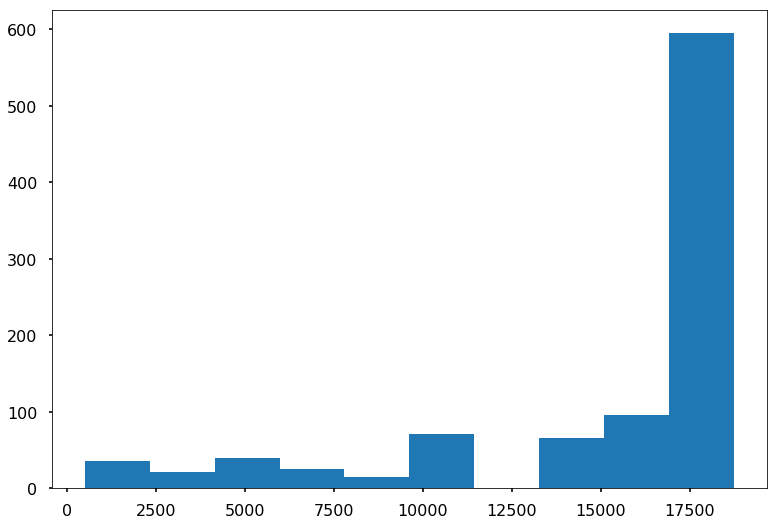

In [14]:
#first build a model to impute using data without missing 
plt.hist(gssdata_full['income'])

##Classifiers should be about the Business End: keeping costs down

(array([  35.,   21.,   39.,   25.,   14.,   71.,    0.,   66.,  684.,  596.]),
 array([   500.,   2325.,   4150.,   5975.,   7800.,   9625.,  11450.,
         13275.,  15100.,  16925.,  18750.]),
 <a list of 10 Patch objects>)

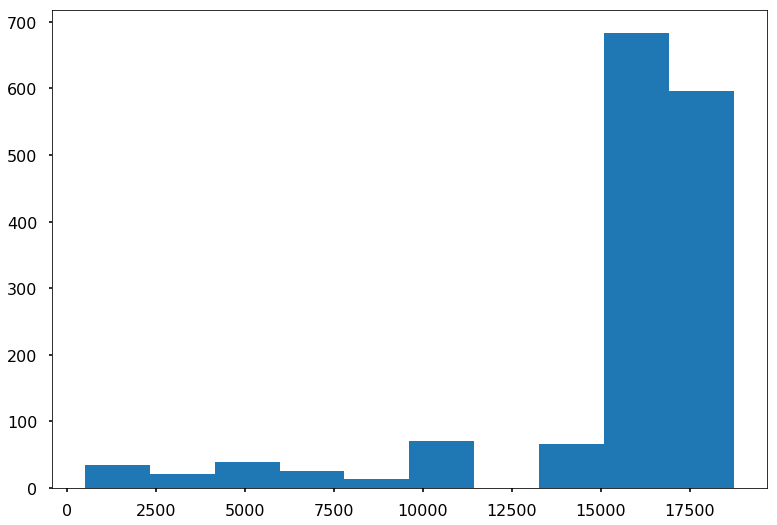

In [15]:
#back to the data set with missingness and impute the mean
gssdata2 = gssdata.copy()
gssdata2['income'] = gssdata['income'].fillna(gssdata_full['income'].mean())
plt.hist(gssdata2['income'])

In [16]:
from sklearn.model_selection import train_test_split
itrain, itest = train_test_split(range(gssdata2.shape[0]), train_size=0.50)
#gsstemp = gssdata_full.drop(['health','fairhealth','goodhealth','excellenthealth','sex','sexornt','partyid','race'],axis=1)
gsstemp = gssdata2[['age','educ','female','partyid_dem','partyid_rep','income']]
X_train2 = gsstemp.iloc[itrain, :]
X_test2 = gsstemp.iloc[itest, :]
y_train2 = gssdata2['poorhealth'].iloc[itrain]
y_test2 = gssdata2['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

logit2 = LogisticRegression(C=1000000)
logit2.fit(X_train2, y_train2) 
print(logit2.score(X_test2,y_test2))
logit2.coef_

0.931701030928


array([[  2.68202867e-02,  -2.58213593e-01,  -1.16508366e-02,
         -6.90339975e-03,  -1.61800100e-02,  -5.47807633e-05]])

In [17]:
#look at confusion tables
print(confusion_matrix(y_test2,t_repredict(logit2, 0.5, X_test2)))
print(confusion_matrix(y_train2,t_repredict(logit2, 0.5, X_train2)))

print(confusion_matrix(y_test2,t_repredict(logit2, 0.1, X_test2)))
print(confusion_matrix(y_train2,t_repredict(logit2, 0.1, X_train2)))

[[722   0]
 [ 53   1]]
[[728   2]
 [ 43   2]]
[[629  93]
 [ 33  21]]
[[638  92]
 [ 26  19]]


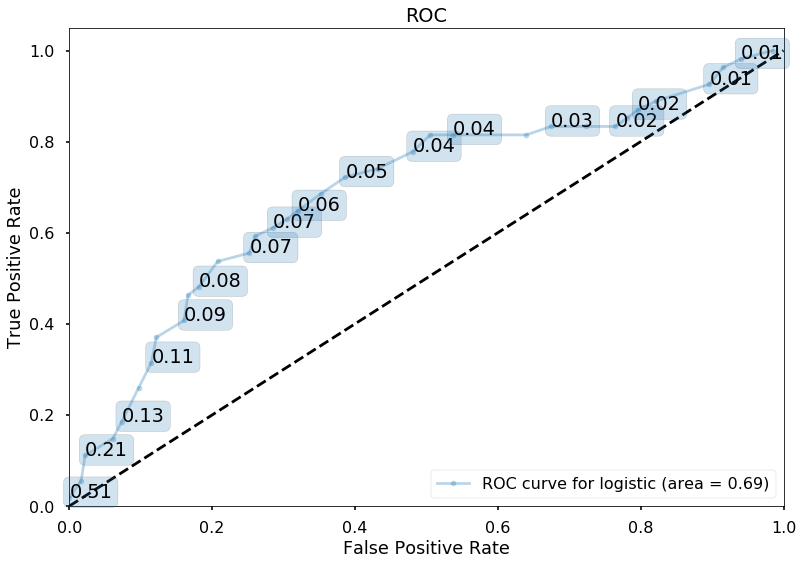

In [18]:
sns.set_context("poster")
ax=make_roc("logistic",logit2, y_test2, X_test2, labe=10, skip=5)

## Impute with a model

(array([   2.,    3.,   26.,   50.,  104.,  142.,  136.,   82.,   36.,    7.]),
 array([ -3764.16620064,   -364.53354906,   3035.09910252,   6434.7317541 ,
          9834.36440569,  13233.99705727,  16633.62970885,  20033.26236043,
         23432.89501201,  26832.52766359,  30232.16031517]),
 <a list of 10 Patch objects>)

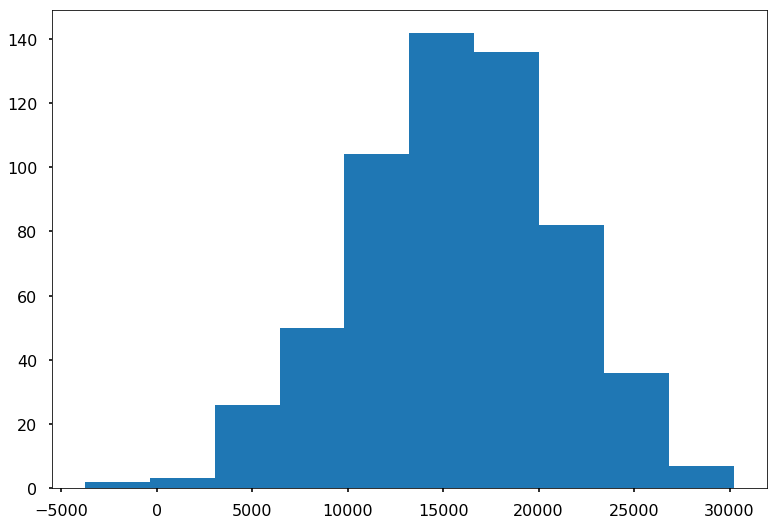

In [19]:
#use the dataset without NAs to build a model
from sklearn.metrics import mean_squared_error

gssdata_full.head()

X_imp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep']]
y_imp = gssdata_full['income']

from sklearn.linear_model import LinearRegression

regress = LinearRegression()
regress.fit(X_imp,y_imp)
y_hat = regress.predict(X_imp)

X_missing = gssdata[gssdata.income.isnull()][['age','educ','female','partyid_dem','partyid_rep']]


y_missing = regress.predict(X_missing)


y_missing_noise = y_missing+np.random.normal(loc=0,scale=np.sqrt(mean_squared_error(y_imp,y_hat)),size=y_missing.shape[0])

plt.hist(y_missing_noise)

In [20]:
missing_index = gssdata.income[gssdata.income.isnull()].index
missing_series = pd.Series(data = y_missing_noise, index = missing_index)

In [21]:
#back to the data set with missingness and impute the predictions
gssdata_imp = gssdata.copy()

gssdata_imp['income'] = gssdata_imp['income'].fillna(missing_series)

(array([   2.,   38.,   86.,   89.,  175.,  304.,  732.,   82.,   36.,    7.]),
 array([ -3764.16620064,   -364.53354906,   3035.09910252,   6434.7317541 ,
          9834.36440569,  13233.99705727,  16633.62970885,  20033.26236043,
         23432.89501201,  26832.52766359,  30232.16031517]),
 <a list of 10 Patch objects>)

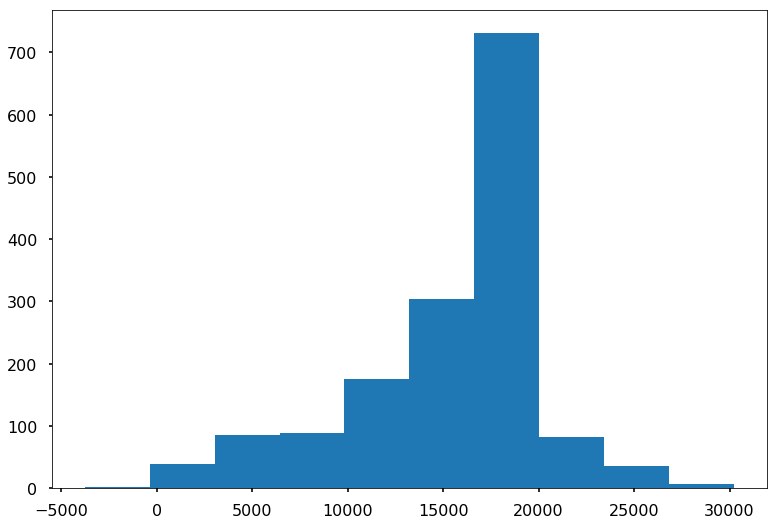

In [22]:
plt.hist(gssdata_imp['income'])

In [23]:
gsstemp = gssdata_imp[['age','educ','female','partyid_dem','partyid_rep','income']]
X_train3 = gsstemp.iloc[itrain, :]
X_test3 = gsstemp.iloc[itest, :]
#y_train3 = gssdata_imp['poorhealth'].iloc[itrain]
#y_test3 = gssdata_imp['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

logit3 = LogisticRegression(C=1000000)
logit3.fit(X_train3, y_train2) 
print(logit3.score(X_test3,y_test2))
logit3.coef_

0.931701030928


array([[  2.41812726e-02,  -2.61014586e-01,  -1.16720301e-02,
         -7.53997499e-03,  -1.09327548e-02,  -4.19918499e-05]])

In [24]:
print(confusion_matrix(y_test2,t_repredict(logit3, 0.5, X_test3)))
print(confusion_matrix(y_train2,t_repredict(logit3, 0.5, X_train3)))

print(confusion_matrix(y_test2,t_repredict(logit3, 0.1, X_test3)))
print(confusion_matrix(y_train2,t_repredict(logit3, 0.1, X_train3)))

[[722   0]
 [ 53   1]]
[[727   3]
 [ 43   2]]
[[632  90]
 [ 35  19]]
[[639  91]
 [ 26  19]]


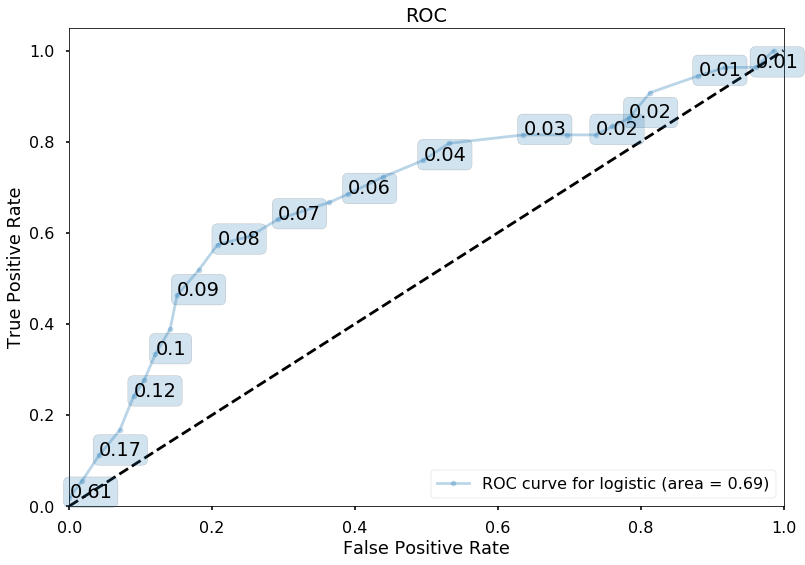

In [25]:
sns.set_context("poster")
ax=make_roc("logistic",logit3, y_test2, X_test3, labe=10, skip=5)